<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_1702_imbalanced_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem of Class Imbalance

**Class imbalance** occurs when one class in a dataset significantly outnumbers the other classes. This is common in many real-world scenarios, such as fraud detection, medical diagnoses, and loan defaults. In such cases, the majority class (the more frequent class) dominates the dataset, while the minority class (the less frequent class) is underrepresented.

### Impact on Model Performance

When training a machine learning model on imbalanced data, the model tends to become biased towards the majority class. This bias can lead to the following issues:

1. **High Accuracy but Poor Minority Class Performance**: The model may achieve high overall accuracy by simply predicting the majority class most of the time. However, it will likely perform poorly on the minority class, failing to identify critical instances.

2. **High Precision and Recall for the Majority Class**: Precision and recall scores for the majority class may be high because the model is good at predicting the majority class correctly. However, this often comes at the expense of poor performance for the minority class.

3. **Low Precision and Recall for the Minority Class**: Precision and recall scores for the minority class are typically low because the model struggles to correctly identify minority class instances. This is problematic in scenarios where identifying the minority class correctly is crucial (e.g., detecting fraudulent transactions or diagnosing diseases).

## Load & Preprocess

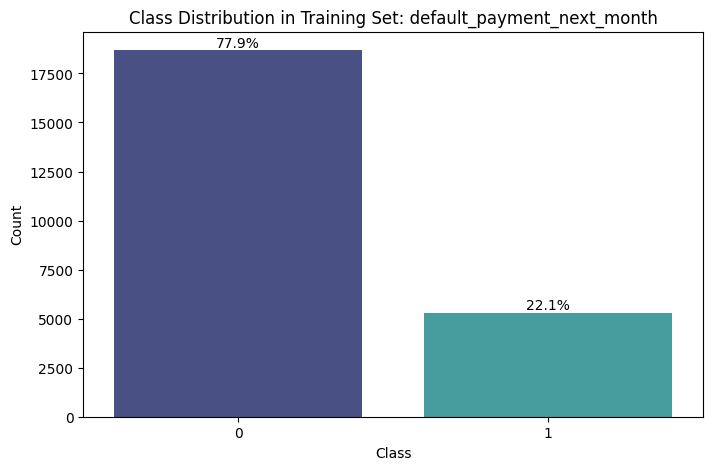

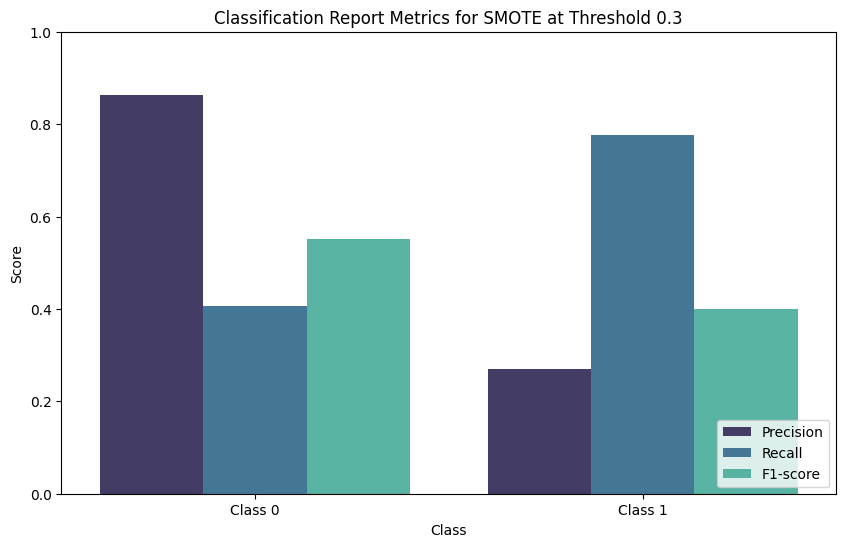

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import json
import warnings
from loan_data_utils import load_and_preprocess_data, plot_class_distribution, plot_classification_report_metrics

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])


# Load the classification reports from the JSON file
with open('resampling_comparison_results.json', 'r') as f:
    results = json.load(f)

# Extract the classification report for SMOTE at threshold 0.3
smote_threshold_0_3_report = results['SMOTE']['Threshold 0.3']

# plot target distribution
plot_class_distribution(y_train, target)
# Plot the classification report metrics for SMOTE at threshold 0.3
plot_classification_report_metrics(smote_threshold_0_3_report, 'SMOTE', '0.3')

## Models that Predict Probabilities ('predict_proba')

In [6]:
import json
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, Lasso, ElasticNet, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Define models that use predict_proba
probability_models = {
    'AdaBoostClassifier': AdaBoostClassifier(random_state=42),
    'HistGradientBoostingClassifier': HistGradientBoostingClassifier(random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LGBMClassifier': LGBMClassifier(force_col_wise=True, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=3000, random_state=42),
    'MLPClassifier': MLPClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42)
}

# Function to adjust thresholds and generate classification reports for probability-based models
def adjust_threshold_proba(model_pipeline, X_test, y_test, threshold):
    y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)
    return classification_report(y_test, y_pred, output_dict=True, zero_division=0)

# Store results
probability_results = {}
threshold = 0.3

# Train and evaluate each probability-based model
for model_name, model in probability_models.items():
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    model_pipeline.fit(X_resampled, y_resampled)

    # Generate and store classification report
    report = adjust_threshold_proba(model_pipeline, X_test, y_test, threshold)
    probability_results[model_name] = report

# Save results to a JSON file
with open('probability_model_comparison_results.json', 'w') as f:
    json.dump(probability_results, f, indent=4)

print("Classification reports for probability-based models saved to 'probability_model_comparison_results.json'")


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Total Bins 3461
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification reports for probability-based models saved to 'probability_model_comparison_results.json'


## Models that Predict with a Decision Function

In [8]:
# Define models that use decision_function or predict
non_probability_models = {
    'ElasticNet': ElasticNet(random_state=42),
    'Lasso': Lasso(random_state=42),
    'Perceptron': Perceptron(random_state=42),
    'SGDClassifier': SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
}

# Function to adjust thresholds and generate classification reports for non-probability-based models
def adjust_threshold_non_proba(model_pipeline, X_test, y_test, threshold):
    if hasattr(model_pipeline['classifier'], 'decision_function'):
        y_scores = model_pipeline.decision_function(X_test)
    else:
        y_scores = model_pipeline.predict(X_test)
    y_pred = (y_scores >= threshold).astype(int)
    return classification_report(y_test, y_pred, output_dict=True, zero_division=0)

# Store results
non_probability_results = {}
threshold = 0.3

# Train and evaluate each non-probability-based model
for model_name, model in non_probability_models.items():
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    model_pipeline.fit(X_resampled, y_resampled)

    # Generate and store classification report
    report = adjust_threshold_non_proba(model_pipeline, X_test, y_test, threshold)
    non_probability_results[model_name] = report

# Save results to a JSON file
with open('non_probability_model_comparison_results.json', 'w') as f:
    json.dump(non_probability_results, f, indent=4)

print("Classification reports for non-probability-based models saved to 'non_probability_model_comparison_results.json'")


Classification reports for non-probability-based models saved to 'non_probability_model_comparison_results.json'


### Plot Results

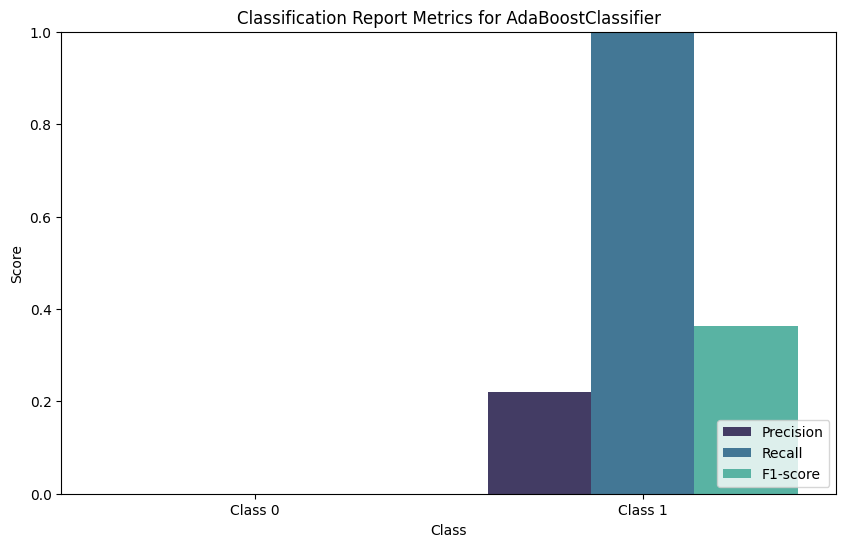

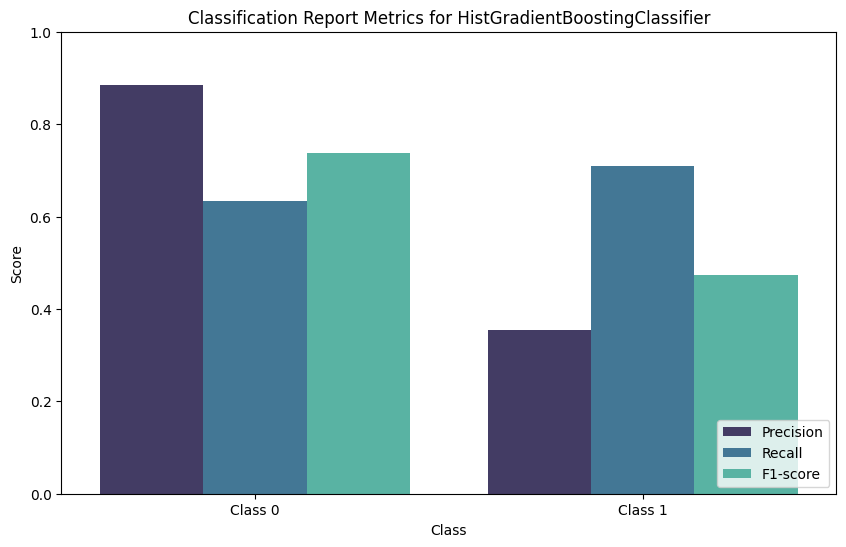

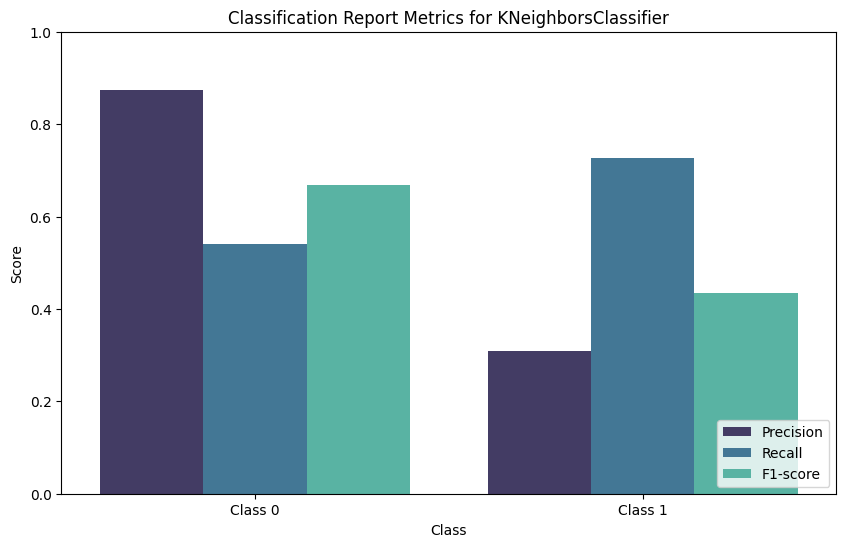

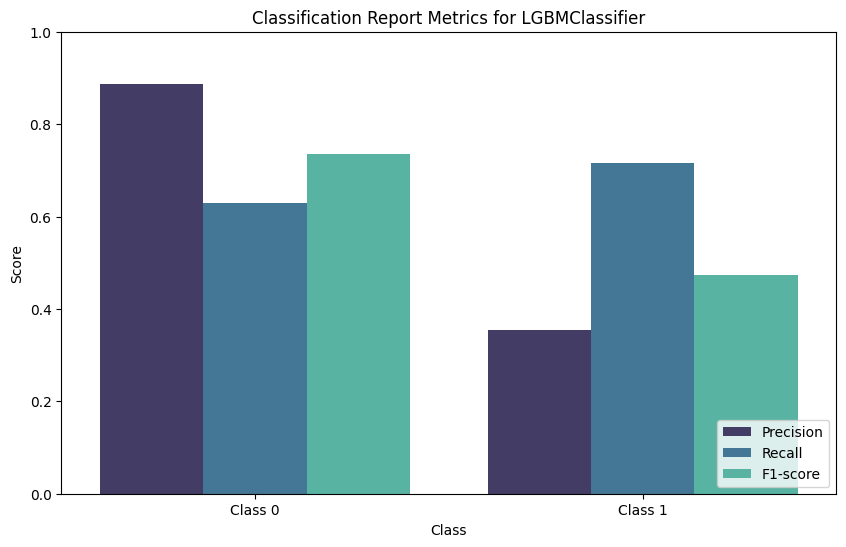

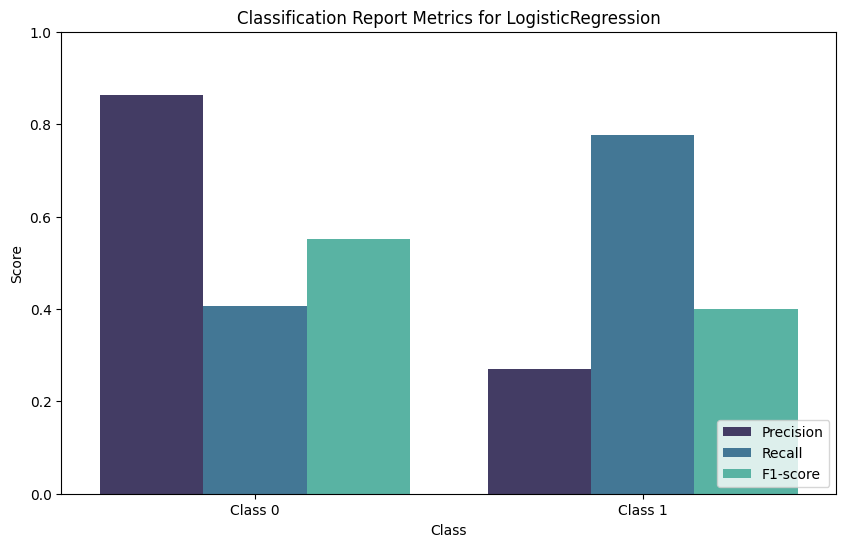

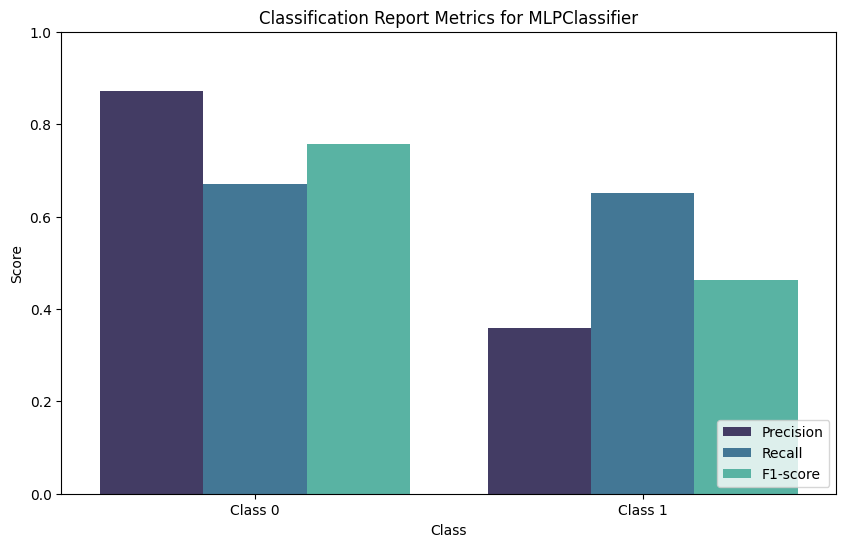

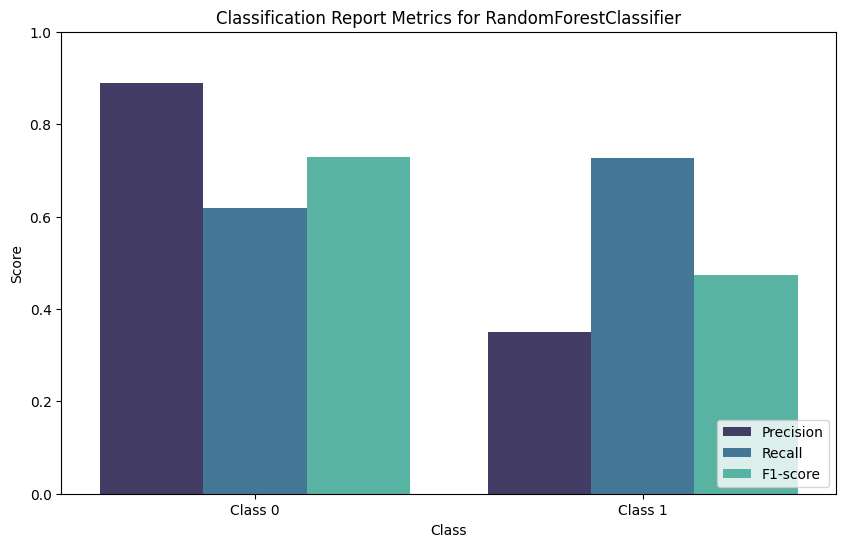

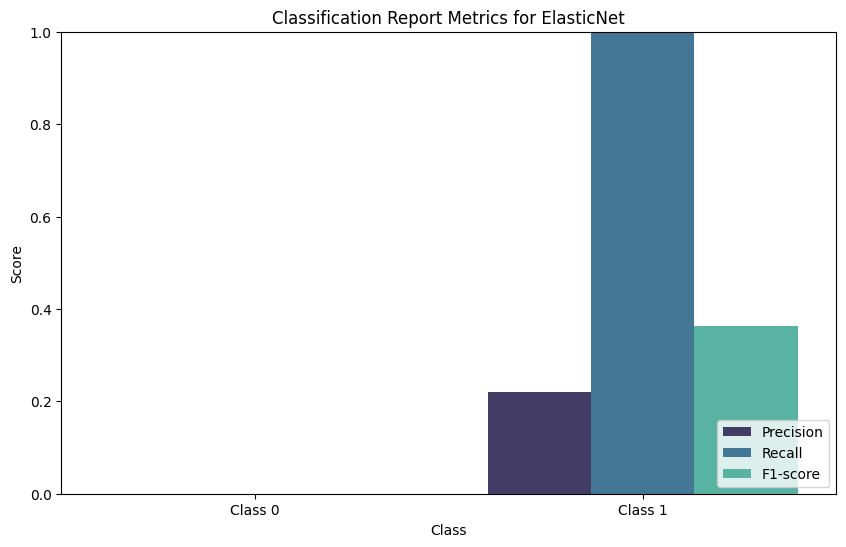

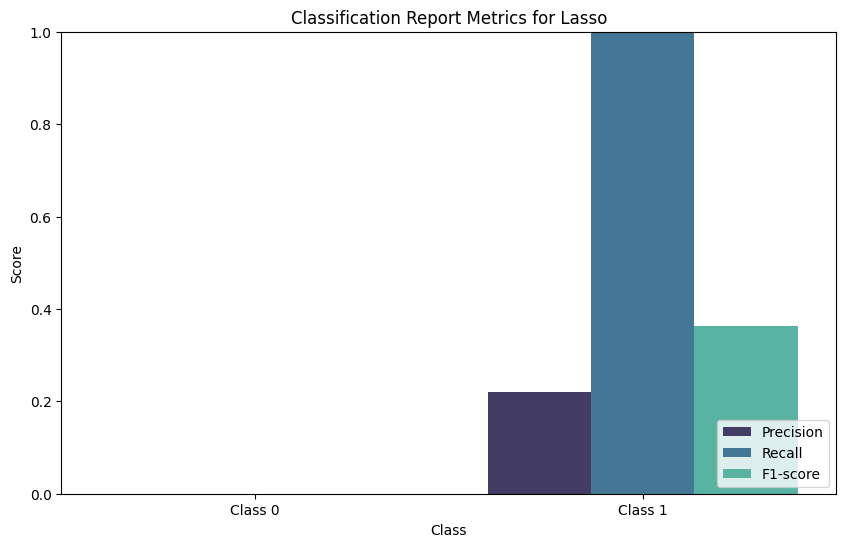

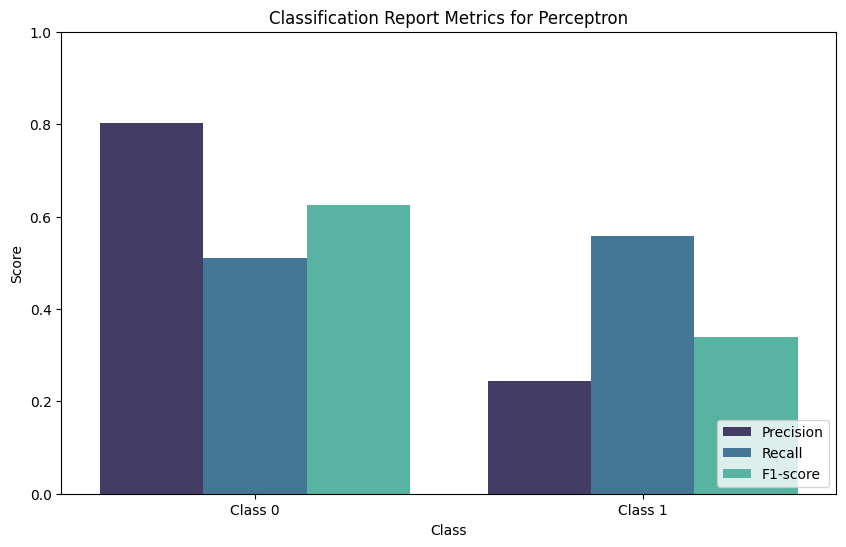

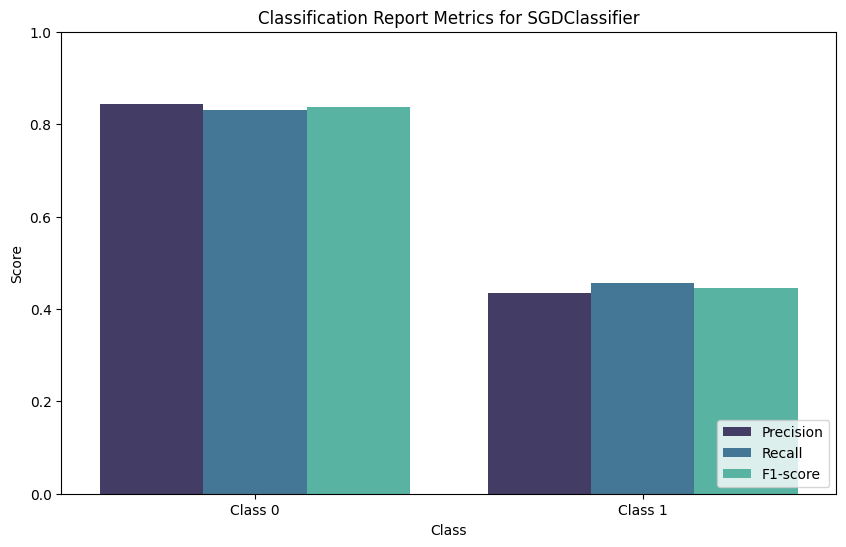

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot classification report metrics
def plot_classification_report_metrics(report, model_name):
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {model_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.show()

# Load and plot metrics for probability-based models
with open('probability_model_comparison_results.json', 'r') as f:
    probability_results = json.load(f)

for model_name, report in probability_results.items():
    plot_classification_report_metrics(report, model_name)

# Load and plot metrics for non-probability-based models
with open('non_probability_model_comparison_results.json', 'r') as f:
    non_probability_results = json.load(f)

for model_name, report in non_probability_results.items():
    plot_classification_report_metrics(report, model_name)


#### Why No Predictions for Class 0?

The behavior you're observing, where the predicted probabilities are clustered tightly around the middle (0.47 to 0.52) and result in predictions only for the minority class, can be attributed to several factors:

1. **Model Miscalibration:** The model may not be well-calibrated, meaning its predicted probabilities do not reflect the true likelihoods. This can happen especially in models like AdaBoost or other ensemble methods if they are not properly tuned or if the class imbalance is not handled adequately during training.

2. **Threshold Setting:** If the threshold is set to 0.3, but the predicted probabilities are clustered around the middle, it suggests the model is not confident in its predictions. This could be due to the model being overly cautious and avoiding extreme probability values.

3. **Data Preprocessing and Scaling:** If the data preprocessing steps (like scaling) are not applied correctly, it can affect the model's ability to learn the true distribution of the data.

4. **Model Sensitivity to Imbalance:** Some models are more sensitive to class imbalance and can exhibit this behavior if they are not properly adjusted to handle the imbalance.

### Steps to Diagnose and Fix the Issue

1. **Check Model Calibration:**
   - Use calibration techniques to ensure that the predicted probabilities reflect the true likelihoods.
   - For example, using `CalibratedClassifierCV` in scikit-learn can help.

2. **Verify Data Preprocessing:**
   - Ensure that data preprocessing steps like scaling and encoding are applied consistently.

3. **Adjust Class Weights:**
   - Many classifiers in scikit-learn have a `class_weight` parameter that can be set to 'balanced' to automatically adjust weights inversely proportional to class frequencies.

4. **Analyze Feature Importance:**
   - Check if the features used by the model are informative and relevant.


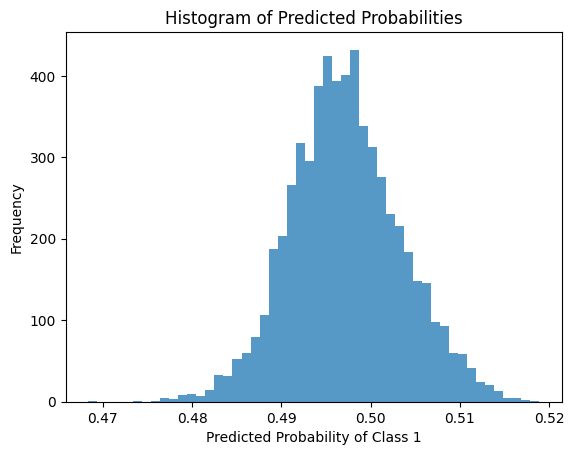

Classification Report for AdaBoostClassifier at Threshold 0.3:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4673
           1       0.22      1.00      0.36      1327

    accuracy                           0.22      6000
   macro avg       0.11      0.50      0.18      6000
weighted avg       0.05      0.22      0.08      6000



In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Function to check predictions before threshold adjustment
def analyze_model_predictions(model_pipeline, X_test):
    y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]
    plt.hist(y_pred_proba, bins=50, alpha=0.75)
    plt.title("Histogram of Predicted Probabilities")
    plt.xlabel("Predicted Probability of Class 1")
    plt.ylabel("Frequency")
    plt.show()
    return y_pred_proba

# Analyze predictions for AdaBoostClassifier
model_name = 'AdaBoostClassifier'
model = AdaBoostClassifier(random_state=42)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

model_pipeline.fit(X_resampled, y_resampled)
y_pred_proba = analyze_model_predictions(model_pipeline, X_test)

# Adjust threshold and generate classification report
threshold = 0.3
y_pred = (y_pred_proba >= threshold).astype(int)
report = classification_report(y_test, y_pred, zero_division=0)
print(f"Classification Report for {model_name} at Threshold {threshold}:")
print(report)


In [18]:
y_pred_proba

array([0.49606805, 0.50356498, 0.49826595, ..., 0.49326477, 0.50126606,
       0.48498966])

`CalibratedClassifierCV` is a tool in scikit-learn that calibrates the predicted probabilities of a classifier to make them more reflective of true probabilities. This is especially useful when the classifier's probability estimates are not well-calibrated, meaning they do not accurately represent the likelihood of an event.

#### How `CalibratedClassifierCV` Works

1. **Calibration Methods:** `CalibratedClassifierCV` supports two main methods for probability calibration:
   - **Sigmoid Calibration (Platt's Scaling):** This method fits a logistic regression model to the scores of the base classifier. It is suitable for scenarios where the base classifier's output is close to a sigmoid function.
   - **Isotonic Regression:** This method fits an isotonic regression model, which is a non-parametric method suitable for cases with more complex relationships between scores and probabilities.

2. **Cross-Validation:** `CalibratedClassifierCV` performs cross-validation to ensure that the calibration is not overfitted to the training data. It splits the training data into folds and uses part of the data to train the base classifier and the rest to calibrate the probabilities.

3. **Base Estimator:** The base classifier is the initial classifier whose probabilities you want to calibrate. `CalibratedClassifierCV` wraps around this base estimator.

### Steps Involved

1. **Train the Base Estimator:** The base estimator is trained on the training data.
2. **Predict Probabilities:** The base estimator predicts probabilities on the calibration data.
3. **Fit the Calibration Model:** The calibration model (sigmoid or isotonic) is fitted to the predicted probabilities and the true labels.
4. **Predict Calibrated Probabilities:** The calibrated model is used to predict probabilities on new data, providing better probability estimates.


### Explanation of Code

1. **Base Estimator:** A `RandomForestClassifier` is used as the base estimator.
2. **CalibratedClassifierCV:** The base estimator is wrapped with `CalibratedClassifierCV`, using sigmoid calibration and 5-fold cross-validation.
3. **Fit:** The calibrated classifier is fitted on the resampled training data.
4. **Predict:** The calibrated probabilities are predicted on the test data, and a threshold is applied to convert probabilities to class labels.
5. **Evaluate:** The classification report is generated to evaluate the performance.

### When to Use Calibration

- **Imbalanced Datasets:** Calibration can be particularly useful in scenarios with imbalanced datasets, where the classifier might be biased towards the majority class.
- **Improving Probability Estimates:** If the classifier's probability estimates are not reliable, calibration can help make them more accurate.
- **Post-processing Step:** Calibration is typically used as a post-processing step after training the base classifier.

By using `CalibratedClassifierCV`, you can improve the reliability of probability estimates from your classifiers, leading to better decision-making in threshold-based classifications.

In [21]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define the base estimator
base_estimator = RandomForestClassifier(random_state=42)

# Wrap the base estimator with CalibratedClassifierCV
calibrated_clf = CalibratedClassifierCV(base_estimator, method='sigmoid', cv=5)

# Fit the calibrated classifier
calibrated_clf.fit(X_resampled, y_resampled)

# Predict probabilities and adjust thresholds
y_pred_proba = calibrated_clf.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred = (y_pred_proba >= threshold).astype(int)

# Generate and print classification report
report = classification_report(y_test, y_pred, zero_division=0)
print(report)


              precision    recall  f1-score   support

           0       0.87      0.78      0.82      4673
           1       0.44      0.60      0.51      1327

    accuracy                           0.74      6000
   macro avg       0.66      0.69      0.67      6000
weighted avg       0.78      0.74      0.75      6000



#### Interpretation and Recommendations

1. **Imbalanced Performance:**
   - The classifier performs better for class 0 (non-default) than for class 1 (default). This is common in imbalanced datasets where the model tends to favor the majority class.

2. **Class 0 Metrics:**
   - The high precision (0.87) indicates that false positives are low for class 0.
   - The recall (0.78) shows that there are some false negatives, meaning not all actual class 0 instances are being correctly identified.

3. **Class 1 Metrics:**
   - The lower precision (0.44) indicates that there are more false positives for class 1.
   - The recall (0.60) is better but still indicates that 40% of actual class 1 instances are missed.

4. **Overall Performance:**
   - The accuracy of 74% suggests that the model is reasonably good at making correct predictions overall.
   - However, the macro average F1-score of 0.67 shows that the performance across classes is not balanced, with class 1 (the minority class) being less well-predicted.

### Recommendations for Improvement

1. **Threshold Tuning:**
   - Experiment with different thresholds to find a better balance between precision and recall for class 1.

2. **Further Calibration:**
   - Continue using `CalibratedClassifierCV` to ensure that the predicted probabilities are well-calibrated.

3. **Feature Engineering:**
   - Create new features that might help the model better distinguish between the classes.

4. **Resampling Techniques:**
   - Use other resampling techniques like SMOTE-ENN or SMOTE-Tomek to improve the representation of the minority class.

5. **Ensemble Methods:**
   - Use ensemble methods like a VotingClassifier or a StackingClassifier to combine multiple models and improve overall performance.

6. **Model Selection:**
   - Try different models and compare their performance to find the best-suited model for this task.

By focusing on these areas, you can aim to improve the recall and precision for class 1, leading to a more balanced and effective model for predicting loan defaults.

#### Data Utils Script

In [1]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import joblib
import json
import logging
# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#--------   Load and Preprocess Data   --------#

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

#--------   Plot Class Distribution   --------#


def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

#--------   Plot Classification Report Metrics   --------#

def plot_classification_report_metrics(report, method_name, threshold):
    """
    Function to plot the precision, recall, and f1-score metrics for class 0 and class 1.
    """
    # Extract metrics from the report
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    # Plot the metrics
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {method_name} at Threshold {threshold}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.show()




#--------   Evaluate and Capture Metrics   --------#

# Function to evaluate model
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, experiment_name):
    logger.info(f"Training and evaluating model: {model_name} ({experiment_name})")

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Capture classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract relevant metrics
    metrics = {
        'Model': model_name,
        'Experiment': experiment_name,
        'Recall_0': report['0']['recall'],
        'Precision_0': report['0']['precision'],
        'F1_0': report['0']['f1-score'],
        'Recall_1': report['1']['recall'],
        'Precision_1': report['1']['precision'],
        'F1_1': report['1']['f1-score'],
        'F1_Macro': report['macro avg']['f1-score'],
        'Accuracy': report['accuracy']
    }
    return metrics


'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *

Script successfully written to loan_data_utils.py
